In [5]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
import Pkg
using PyPlot

In [6]:
lemur_params = lemur_obj();

k undercapacity z dx 1000.0
here2 2 
dy 1000.0
here2 3 
t 300000.0
here2dt 100000.0
here2display 1.0
here2Udt 0.0
here2flex 10000.0
here2kd 1.0
here2m 0.5
here2n 1.0
here2bc wdt 0.0
here2firstcall 1.0
here2u udt 100000.0
here2ny 500.0
here2nx 500.0
here2deposit 0.0
here2srho 2400.0
here2drawdt 0.0
here2l 1.0
here2ks 0.0
here2sinkfill 1.0
here2uselandsed 0.0
here2maxareasinkfill 1.0e6
here2precip 1.0
here2evaprate 1.0e-30
here2bcx k_sed heret: parameter not founddisplay: parameter not foundUdt: parameter not foundflex: parameter not foundwdt: parameter not foundudt: parameter not foundny: parameter not foundnx: parameter not founddeposit: parameter not foundsrho: parameter not founddrawdt: parameter not foundsinkfill: parameter not foundbcx: parameter not foundk_sed: parameter not foundzz0
here
1
z0
here
1
z0
here
1
z0
here


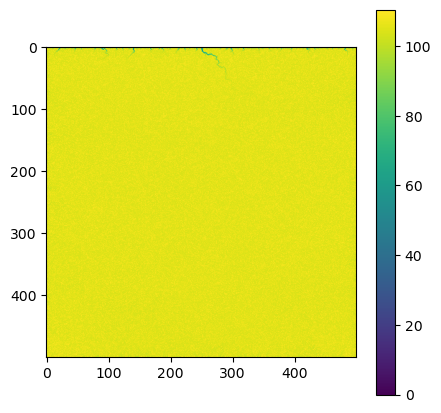

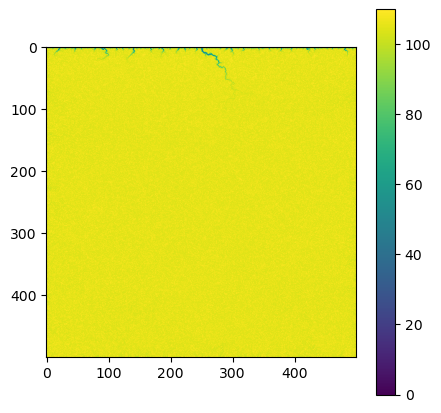

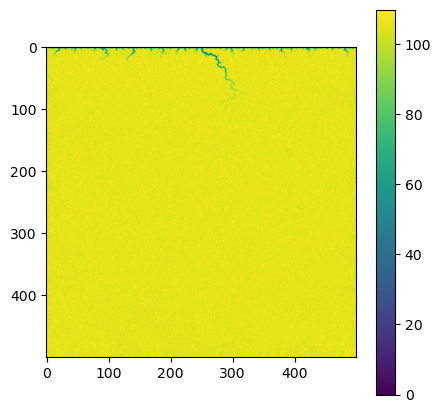

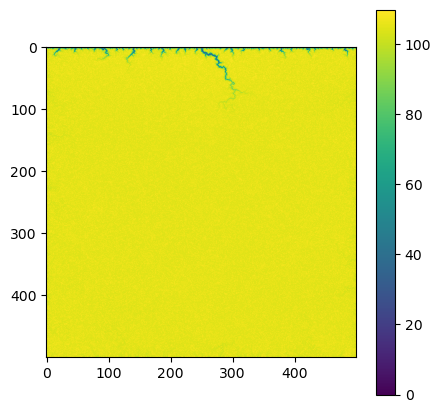

1
z

In [7]:
run_lemur.run(lemur_params);

In [2]:
using AbstractPlotting, WGLMakie
surface(z,colormap = Reverse(:Spectral))

UndefVarError: UndefVarError: z not defined

UndefVarError: UndefVarError: z not defined

In [ ]:
a = run_lemur.set_lemur(model, "z", lemur_params.z)
z = copy(run_lemur.get_lemur(model, "bc", lemur_params.ny, lemur_params.nx))

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/gr_1/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError('Image data of dtype object cannot be converted to float')
  File "/Users/gr_1/.julia/conda/3/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2724, in imshow
    __ret = gca().imshow(
  File "/Users/gr_1/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/gr_1/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 5523, in imshow
    im.set_data(X)
  File "/Users/gr_1/.julia/conda/3/lib/python3.8/site-packages/matplotlib/image.py", line 700, in set_data
    raise TypeError("Image data of dtype {} cannot be converted to "
